In [1]:
import torch as t
from PIL import Image
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm

In [2]:
class STESpike(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output


In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)])

def get_moore_nbh(batch:t.tensor):
    batch_size, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    moore_nbhs = []
    for batch_idx in range(batch_size):
        batch_slice = cell_pixel_coords[:, 0] == batch_idx
        #print(cell_pixel_coords[batch_slice])
        coords = cell_pixel_coords[batch_slice]
        batch_moore_nbhs = []
        for coord in coords:
            nbh_coords = coord[1:]+MOORE_OFFSETS
            nbh_coords[nbh_coords == -1] = 1
            nbh_coords[nbh_coords == batch_height] = batch_height -2
            idx_pad = t.zeros(8,1) + batch_idx
            nbh_coords = t.vstack((coord, t.hstack((idx_pad, nbh_coords))))
            #print(nbh_coords)
            batch_moore_nbhs.append(nbh_coords)
        res = t.vstack(batch_moore_nbhs).unique(dim=0)
        moore_nbhs.append(res)
    return moore_nbhs


In [4]:
def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    for batch_idx, frontier in enumerate(frontiers):
        #print(frontier)
        src_coords = random.choice(frontier).type(t.long)
        step_size = random.choice(MOORE_OFFSETS)
        tgt_coords = src_coords.clone()
        tgt_coords[1:] += step_size
        tgt_coords[1:][tgt_coords[1:] == -1] = 1
        tgt_coords[1:][tgt_coords[1:] == batch_height] = batch_height -2
        #print(batch_idx)
        #print(f"coordinates of the source pixel on the grid: {src_coords}")
        #print(f"step size: {step_size}")
        #print(f"coordinates of the target pixel on the grid: {tgt_coords}")
        src_i, src_j, src_k = src_coords
        tgt_i, tgt_j, tgt_k = tgt_coords
        
        #print(batch[batch_idx])
        cur_vol = t.sum(batch[batch_idx])
        vol_change = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
        #print("vol change", vol_change)
        adjusted_vol = cur_vol + vol_change
        #print(f"adjusted vol: {adjusted_vol}")
        if batch[tgt_i, tgt_j, tgt_k] == batch[src_i, src_j, src_k]:
            # source is equal to target, no update
            #print("source is equal to target, no update")
            pass
        elif adjusted_vol > 2 or adjusted_vol <= 0:
            # Changes would violate the hard constraints, no update
            #print("Changes would violate the hard constraints, no update")
            pass
        elif cur_vol == 2 and vol_change == -1:
            # Negative Hamiltonian, accepted
            #print("Negative Hamiltonian, accepted")
            batch[tgt_i, tgt_j, tgt_k] += vol_change
        else:
            update_probability = t.exp(-((target_vol - adjusted_vol) ** 2) / temperature)
            #print(f"update probability: {update_probability}")
            
            residual = t.rand(1)
            #print(residual)
            
            upd_val = STESpike.apply(update_probability - residual) * vol_change
            
            #print(upd_val)
            
            #print(batch[tgt_i, tgt_j, tgt_k])
            #print(batch[tgt_i, tgt_j, tgt_k] + upd_val)

            batch[tgt_i, tgt_j, tgt_k] += upd_val.squeeze()
    return batch

In [5]:
init_state = t.zeros(2,8,8)
init_state[:,4,4] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0], return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix)

print(dist_matrix_t)

target_vol = 0.
temperature = t.tensor(27.)
temperature.requires_grad_()

tensor([[32.0000, 25.0000, 20.0000, 17.0000, 16.0000, 17.0000, 20.0000, 25.0000],
        [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000, 18.0000],
        [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000, 13.0000],
        [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000, 10.0000],
        [16.0000,  9.0000,  4.0000,  1.0000,  0.0000,  1.0000,  4.0000,  9.0000],
        [17.0000, 10.0000,  5.0000,  2.0000,  1.0000,  2.0000,  5.0000, 10.0000],
        [20.0000, 13.0000,  8.0000,  5.0000,  4.0000,  5.0000,  8.0000, 13.0000],
        [25.0000, 18.0000, 13.0000, 10.0000,  9.0000, 10.0000, 13.0000, 18.0000]],
       dtype=torch.float64)


tensor(27., requires_grad=True)

In [6]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in range(40):
        #print(f"-------- MCS {i} --------------")
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 1000 steps    
    dist = t.sum(t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2)))
    #dist = t.sum((batch - ref_state)**2)
    #print(dist)
    grad = t.autograd.grad(dist, temperature)[0]
    return t.clamp(temperature - eta * grad, min=t.tensor(1e-5), max=t.tensor(40.)), grad

In [ ]:
states = [init_state.detach().clone().squeeze().numpy()]
state = init_state.detach().clone()
for i in range(40):
    #print(f"-------- MCS {i} --------------")
    state = MCS(state, target_vol, temperature)
    print(state.detach())
    dist = t.sum(t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2)))
    print(dist.detach())
    states.append(state.detach().clone().squeeze().numpy())
    if t.any(t.sum(state, dim=(-1,-2)) == 0) or t.any(t.sum(state, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM",t.sum(state))
        break

In [53]:
t.autograd.grad(dist, temperature)

(tensor(0.0024),)

In [126]:
batch_idx = 1
imgs = [Image.fromarray((1-state[batch_idx])*255) for state in states]
imgs[0].save("t_27_reflective.gif", save_all=True, append_images=imgs[1:], duration=20, loop=100)

In [7]:
grads = []
temps = []
for i in tqdm(range(2000)):
    init_state = t.zeros(2,8,8)
    init_state[:,4,4] += 1
    temperature, grad = step(init_state, dist_matrix_t, temperature, target_vol, eta=5)
    if temperature == None or grad == None:
        print("issue encountered in the simulations, stopping training")
        break
    else:
        grads.append(grad.detach().cpu().numpy())
        temps.append(temperature.detach().cpu().numpy())

100%|██████████| 2000/2000 [01:15<00:00, 26.37it/s]


Text(0, 0.5, 'temperature')

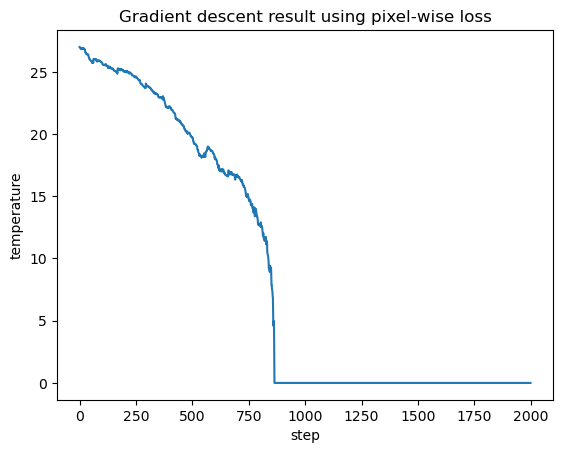

In [9]:
plt.plot(np.arange(2000), temps)
plt.title("Gradient descent result using pixel-wise loss")
plt.xlabel("step")
plt.ylabel("temperature")

Text(0, 0.5, 'log-grad')

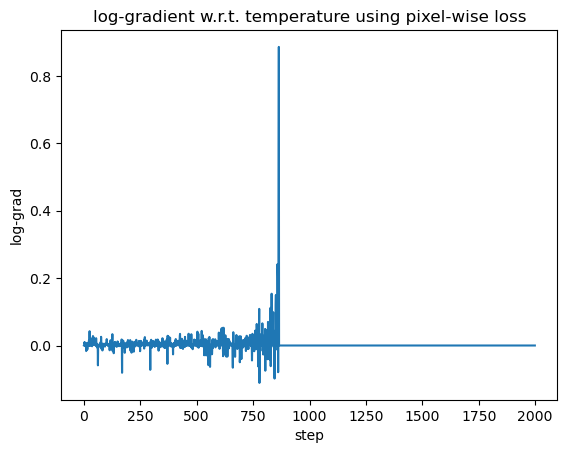

In [11]:
plt.plot(np.arange(2000), grads)
plt.title("log-gradient w.r.t. temperature using pixel-wise loss")
plt.xlabel("step")
plt.ylabel("log-grad")

Text(0.5, 0.98, 'Gradient Descent on temperature using Distance-Matrix loss')

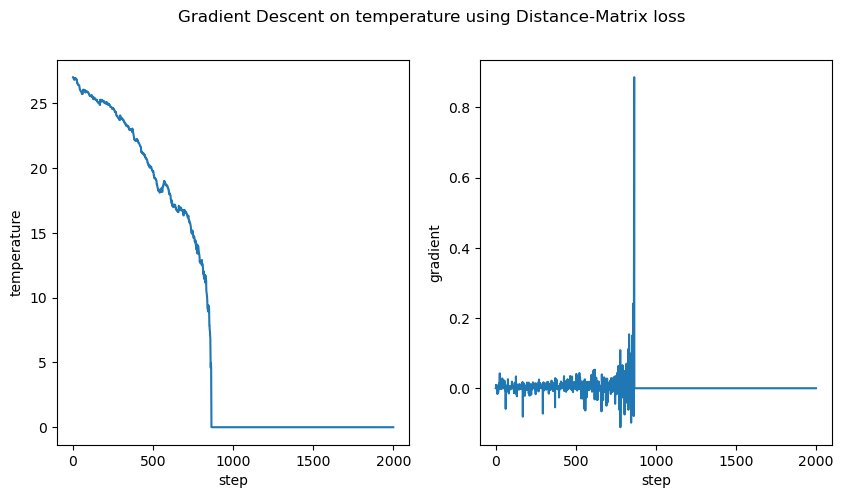

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(np.arange(2000), temps)
axs[0].set(xlabel="step", ylabel="temperature")
axs[1].plot(np.arange(2000), grads)
axs[1].set(xlabel="step", ylabel="gradient")
fig.suptitle("Gradient Descent on temperature using Distance-Matrix loss")